In [61]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.impute import KNNImputer
import xgboost as xgb
sns.set_theme()
sns.set(font_scale=1.2)
plt.style.use('seaborn-whitegrid')
palette=None

In [62]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [63]:
print("Train dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Train dataset shape: (8693, 14)
Test dataset shape: (4277, 13)


In [64]:
miss = round(100 * train.isnull().sum() / train.shape[0], 2)
miss_df = pd.DataFrame({'% of missing values':miss})
miss_df

,% of missing values
PassengerId,0.00
HomePlanet,2.31
CryoSleep,2.50
Cabin,2.29
Destination,2.09
Age,2.06
VIP,2.34
RoomService,2.08
FoodCourt,2.11
ShoppingMall,2.39


The overall percentage of transported passengers is: 50.4%


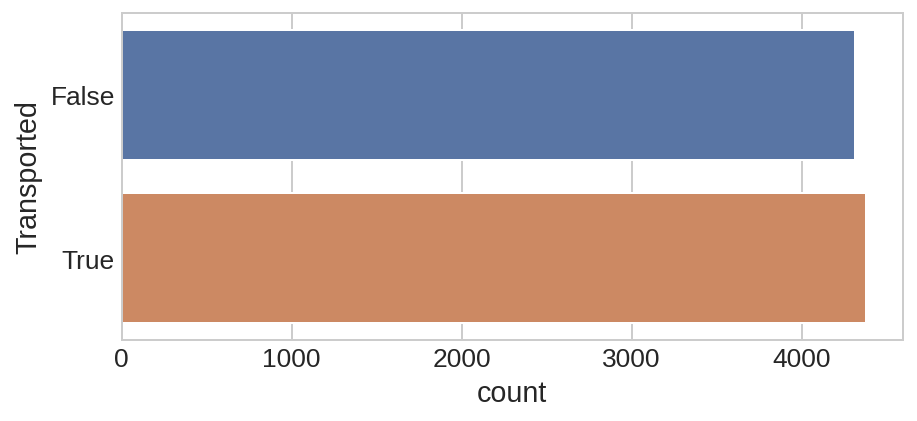

In [65]:
fig, ax1 = plt.subplots(figsize=(7, 3))
sns.countplot(data=train, y='Transported', ax = ax1, orient='h', palette=palette)
transported_perc = 100 * ((train['Transported'] == True).sum()) / ((train['Transported'] == True).count())
print('The overall percentage of transported passengers is: {:.1f}%'.format(transported_perc))

In [66]:
def plot_categorical_feature (feature, data=train):
    
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    fig.subplots_adjust(hspace=0.3)
   
    values = list(pd.Series(data[feature].unique()).sort_values()) 

    if np.nan in values:
        values.remove(np.nan)
    
    sns.barplot(data=data, x=feature, y='Transported', order=values, ax=axs[0], palette=palette)
    sns.despine() 
    axs[0].set_xlabel('')
    if feature == 'Destination': axs[0].xtick_params(axis='x', labelrotation=10)
    axs[0].set_title(feature)
    
    # Build Pieplot
    sizes = []
    for value in values:
        sizes.append(data.loc[data[feature]==value, feature].size)
    explode = []
    for size in sizes:
        if size == max(sizes):
            explode.append(0.06)
        else:
            explode.append(0)
    
    w, _, autotexts = axs[1].pie(sizes, explode=explode, shadow=True, autopct='%1.0f%%', colors=palette)
    

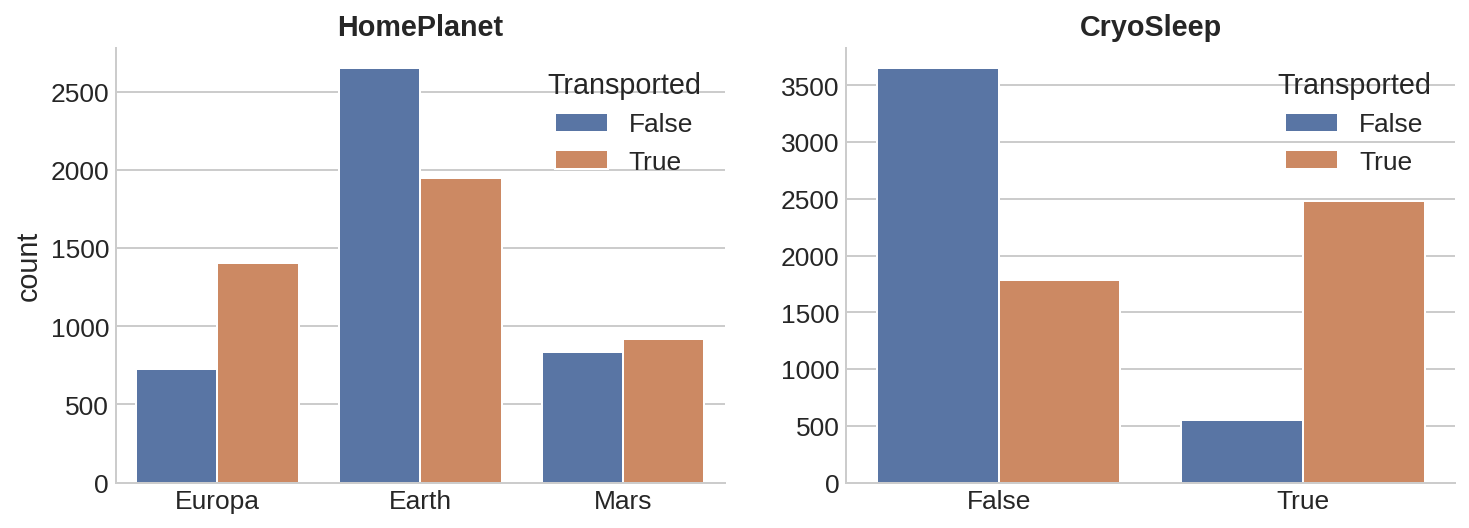

In [67]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
sns.countplot(data=train, x='HomePlanet', hue='Transported', ax=axs[0])
axs[0].set_title('HomePlanet', fontweight='bold')
axs[0].set_xlabel('')
sns.despine()
    
sns.countplot(data=train, x='CryoSleep', hue='Transported', ax=axs[1])
axs[1].set_title('CryoSleep', fontweight='bold')
axs[1].set_xlabel('')
axs[1].set_ylabel('')
sns.despine()

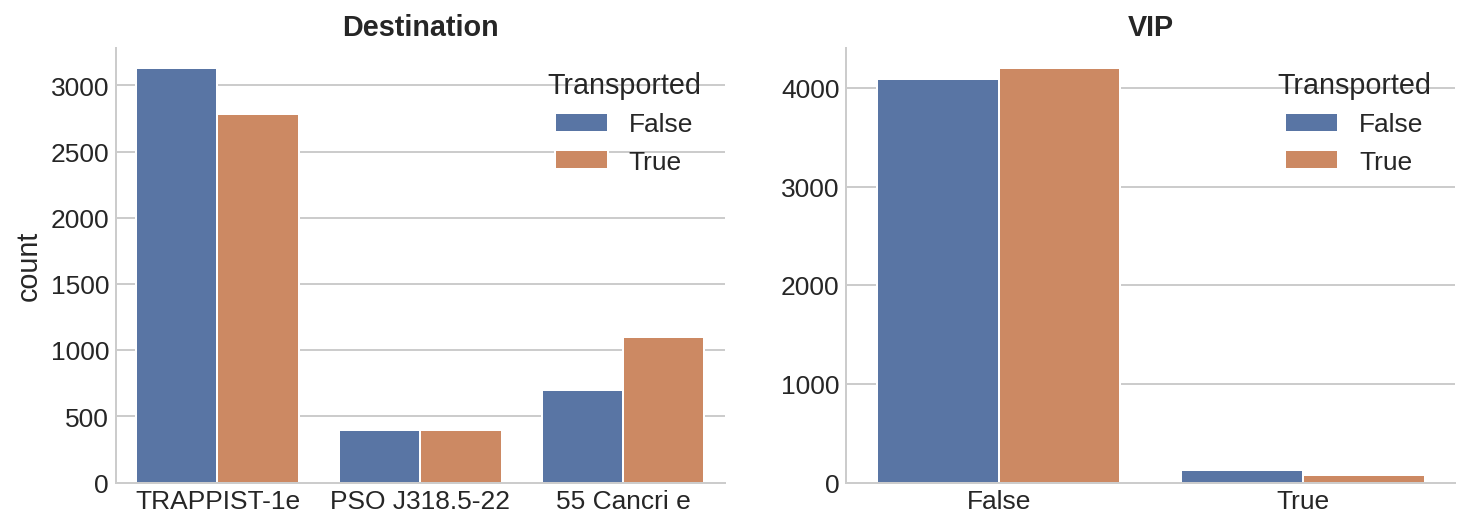

In [68]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
sns.countplot(data=train, x='Destination', hue='Transported', ax=axs[0])
axs[0].set_title('Destination', fontweight='bold')
axs[0].set_xlabel('')
sns.despine()
    
sns.countplot(data=train, x='VIP', hue='Transported', ax=axs[1])
axs[1].set_title('VIP', fontweight='bold')
axs[1].set_xlabel('')
axs[1].set_ylabel('')
sns.despine()

In [69]:
visual_data = {'Deck': list(train['Cabin'].str.split('/', expand = True)[0].copy()),
               'DeckSide': list(train['Cabin'].str.split('/', expand = True)[2].copy()),
               'Transported': list(train['Transported'].copy())}

visual = pd.DataFrame(visual_data)

In [70]:
def bool_cabin(value):
    if value=='B' or value=='C':
        return 1
    elif value in ['F', 'A', 'G', 'E', 'D', 'T']:
        return 0
    else:
        return value
    
visual['Deck_BC'] = visual['Deck'].apply(bool_cabin)

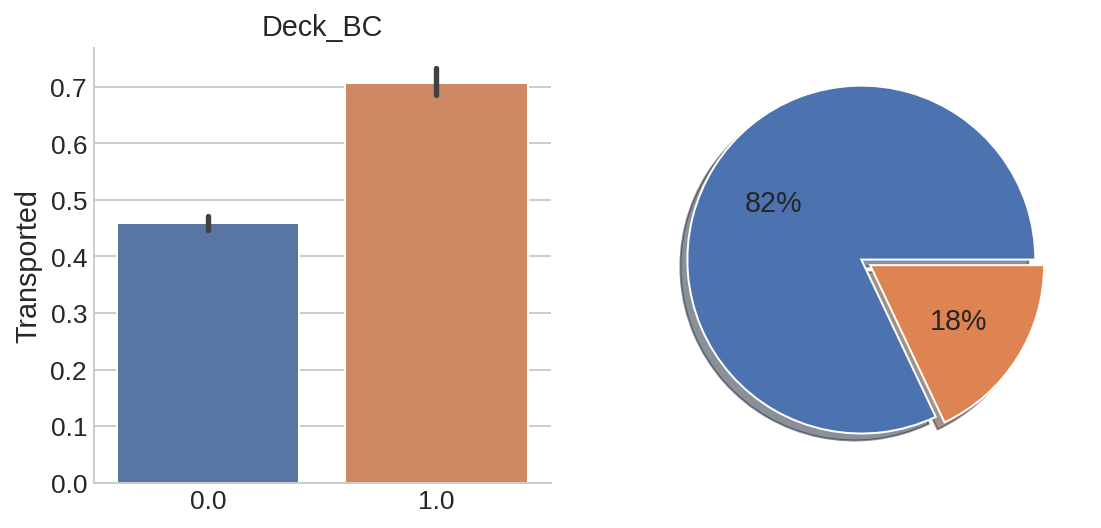

In [71]:
features = ['Deck_BC']
visual = visual.dropna()
plot_categorical_feature('Deck_BC', data=visual)
plt.show()

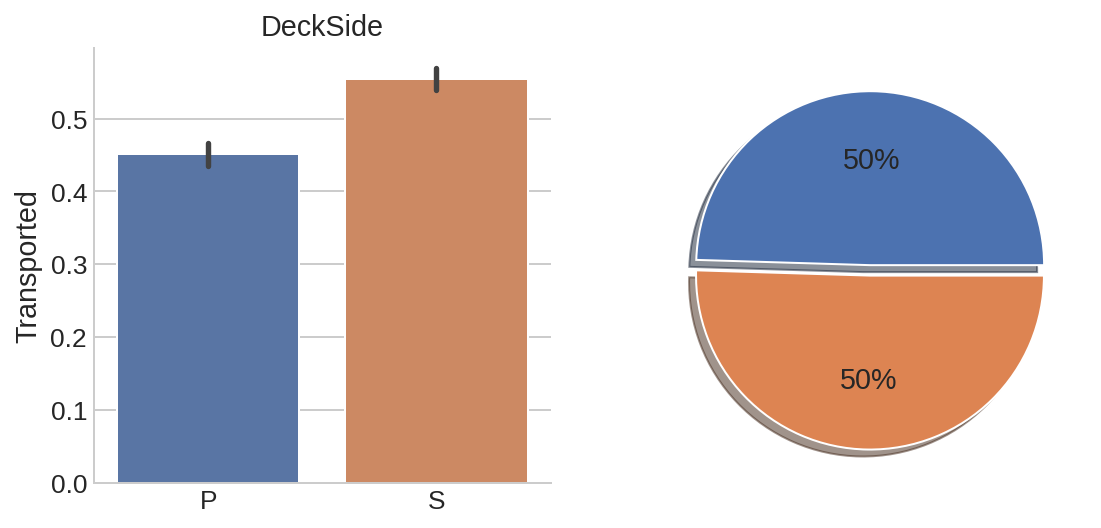

In [72]:
plot_categorical_feature('DeckSide', data=visual)

In [73]:
visual = train.copy()
visual['CabinNumber'] = (visual['Cabin'].str.split('/', expand = True)[1]).copy()
visual = visual[~visual['CabinNumber'].isnull()].copy()
visual['CabinNumber'] = visual['CabinNumber'].astype('int32')

In [74]:
visual['CabinNumber'].unique()

array([   0,    1,    2, ..., 1892, 1893, 1894], dtype=int32)

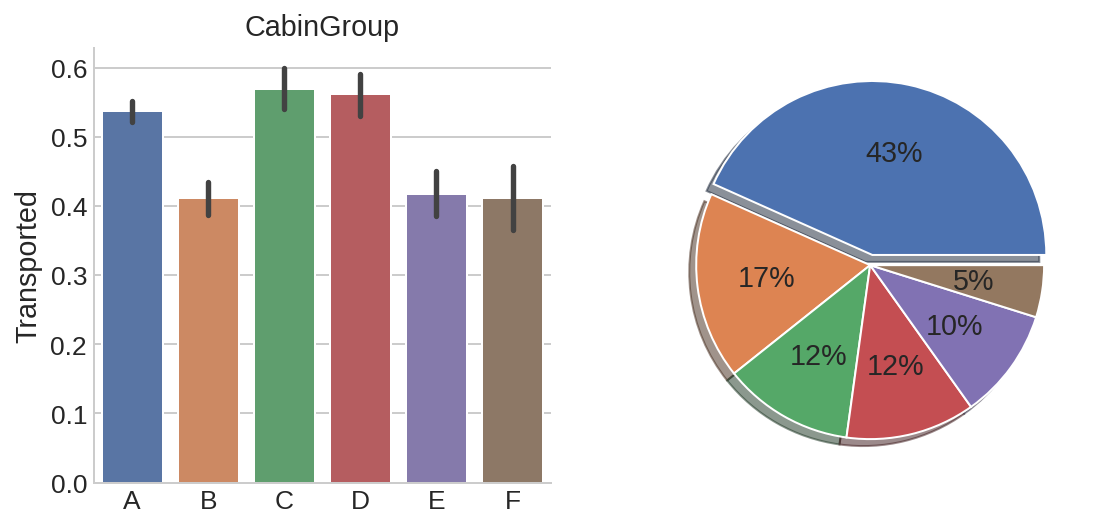

In [75]:
labels = ['A', 'B', 'C', 'D', 'E', 'F']
visual['CabinGroup'] = pd.cut(visual['CabinNumber'], 6, labels=labels)
plot_categorical_feature('CabinGroup', data=visual)

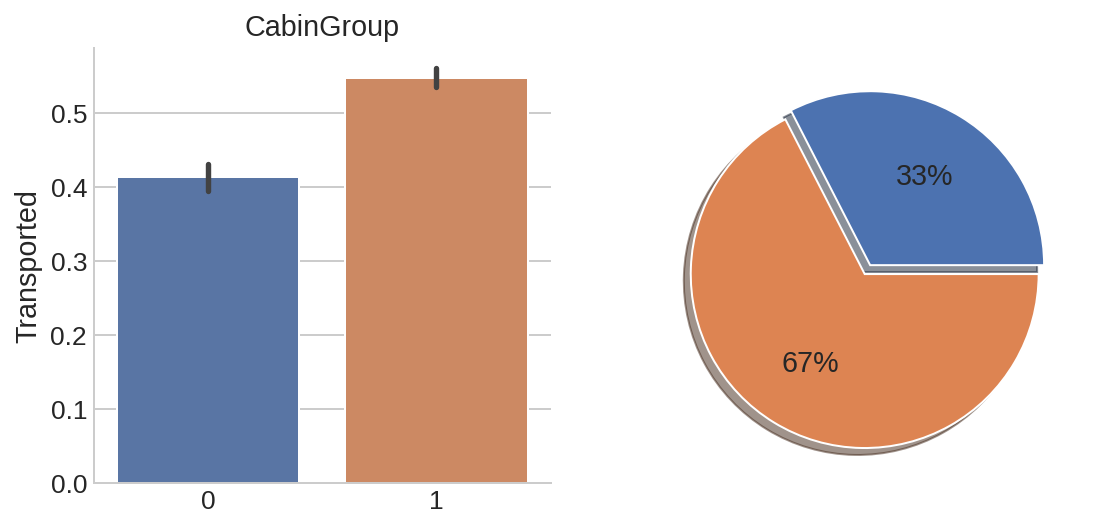

In [76]:
def extract_cabin_group(value):
    if value in ['A', 'C', 'D']:
        return 1
    elif value in ['B', 'E', 'F']:
        return 0
    else:
        return value
visual['CabinGroup'] = visual['CabinGroup'].apply(extract_cabin_group)
plot_categorical_feature('CabinGroup', data=visual)

In [77]:
train['PassengerId'].head()

0    0001_01
1    0002_01
2    0003_01
3    0003_02
4    0004_01
Name: PassengerId, dtype: object

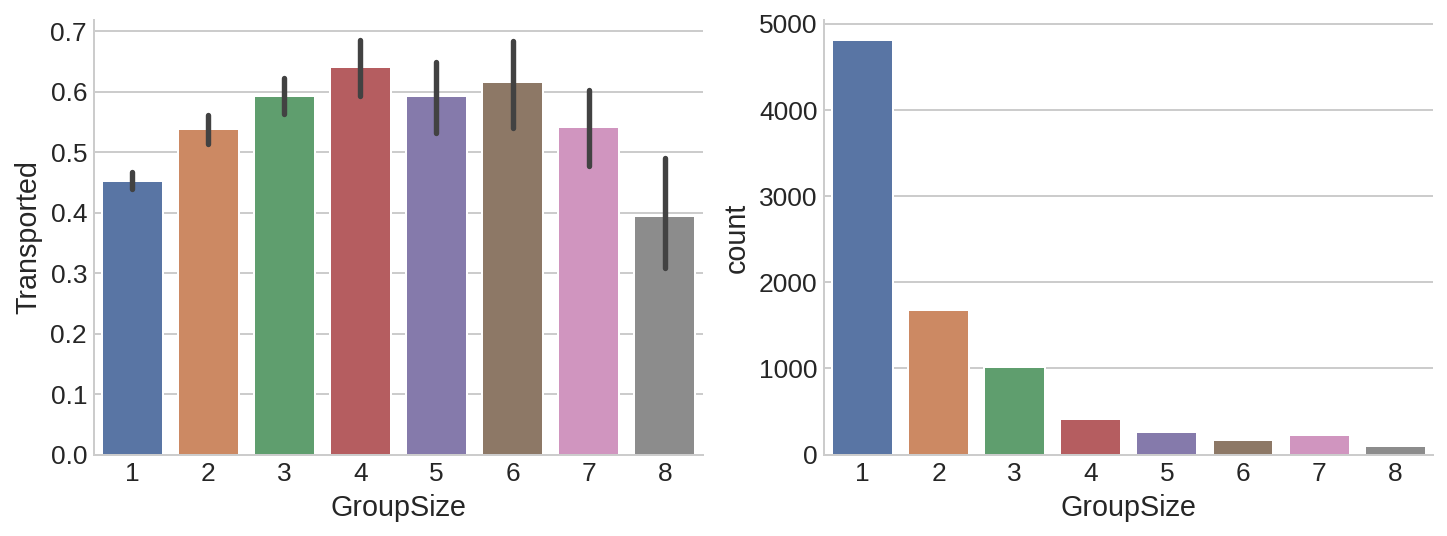

In [78]:
values = list(train['PassengerId'].str.split('_', expand=True)[0].copy())

group_data = {'Pgroup':values}

visual = pd.DataFrame(group_data)
visual['GroupSize'] = 0
visual['Transported'] = train['Transported'].copy()

groups = list(visual.groupby('Pgroup')['Pgroup'].groups.keys())

values = list(visual.groupby('Pgroup')['Pgroup'].count())

for group, value in zip(groups, values):
    visual.loc[visual['Pgroup'] == group, 'GroupSize'] = visual.loc[visual['Pgroup'] == group, 'GroupSize'].apply(lambda x: value)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(data=visual, x='GroupSize', y='Transported', ax=axs[0])
sns.despine()

sns.countplot(data=visual, x='GroupSize', ax=axs[1])
sns.despine()

plt.show()

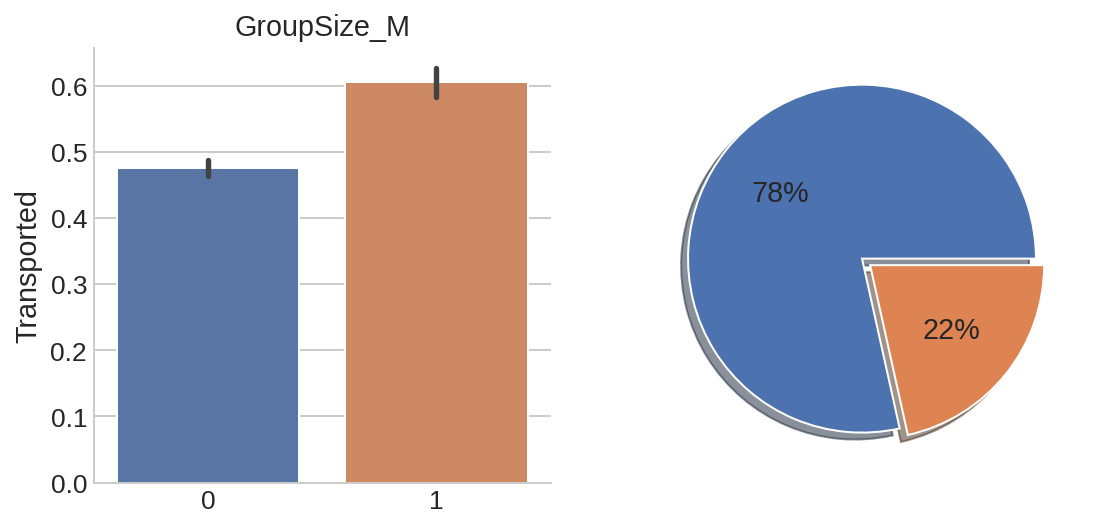

In [79]:
def group_class(value):
    if value in [3,4,5,6]:
        return 1
    else:
        return 0
visual['GroupSize_M'] = visual['GroupSize'].apply(group_class)
plot_categorical_feature('GroupSize_M', data=visual)
plt.show()

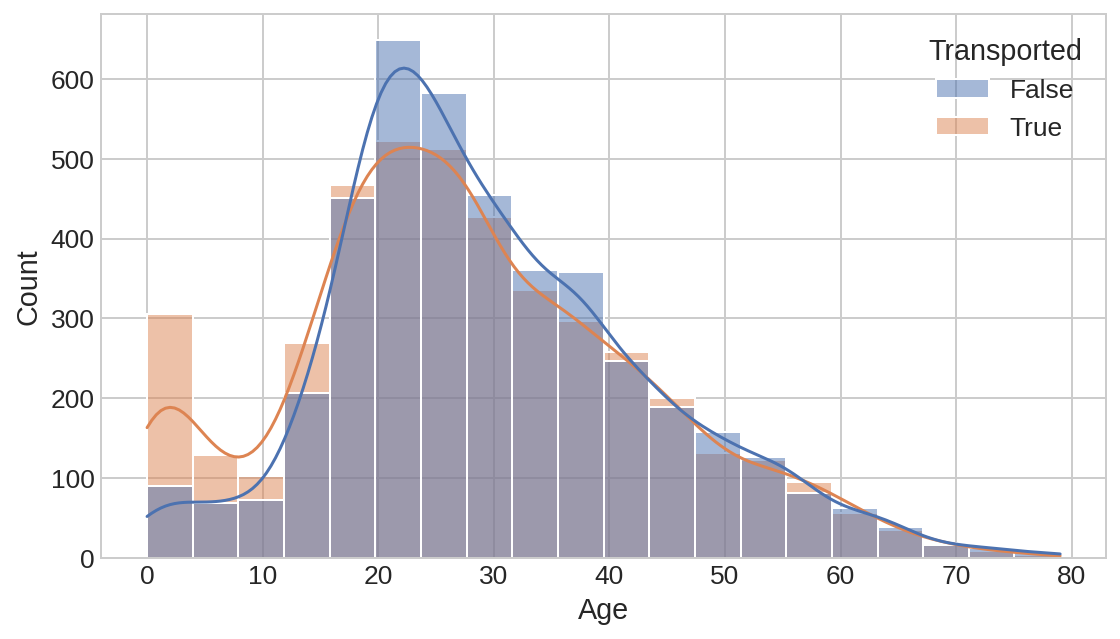

In [80]:
fig, ax = plt.subplots(figsize=(9,5))

sns.histplot(data=train, x='Age', hue='Transported', bins=20, kde=True, ax=ax, palette=palette)

plt.show()

In [81]:
train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].describe()


,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,224.687617,458.077203,173.729169,311.138778,304.854791
std,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,76.000000,27.000000,59.000000,46.000000
max,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


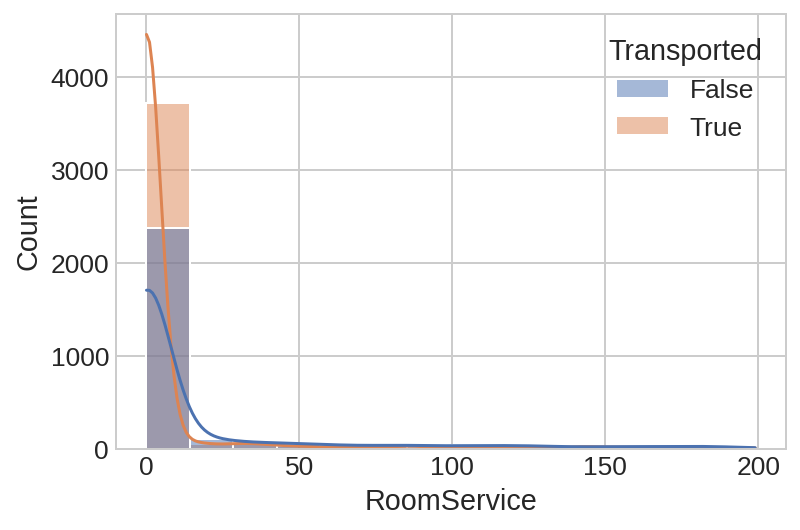

In [82]:
sns.histplot(data=train[train['RoomService']<200], x='RoomService', hue='Transported', kde=True)

plt.show()

In [83]:
def no_exp(value):
    if value == 0:
        return 1
    elif value >=0:
        return 0
    else:
        return value
    
def plot_numerical_features(features):
    
    fig, axs = plt.subplots(2,3,figsize=(16,8))
    
    i = 0

    for feature in features:

        # Plot 1
        mask = visual[feature] != 0

        sns.histplot(data=visual[mask], x=np.log(1 + visual.loc[mask, feature]), hue='Transported', kde=True, ax=axs[0, i], palette=palette)

        sns.despine()
        
        axs[0,i].set_title(feature)
        axs[0,i].set_xlabel('')

        if i != 1: axs[0,i].legend('')

        if i != 0: axs[0,i].set_ylabel('')

            
        # Plot 2
        visual[feature+'_NoExp'] = visual[feature].apply(no_exp)

        sns.countplot(data=visual, x=visual[feature+'_NoExp'], hue='Transported', ax=axs[1, i], alpha=0.95, palette=palette)
        
        sns.despine()
        
        if i != 1: axs[1,i].legend('')

        if i != 0: 
            axs[1,i].set_ylabel('')
        else:
            axs[1,i].set_ylabel('Count')

        i +=1

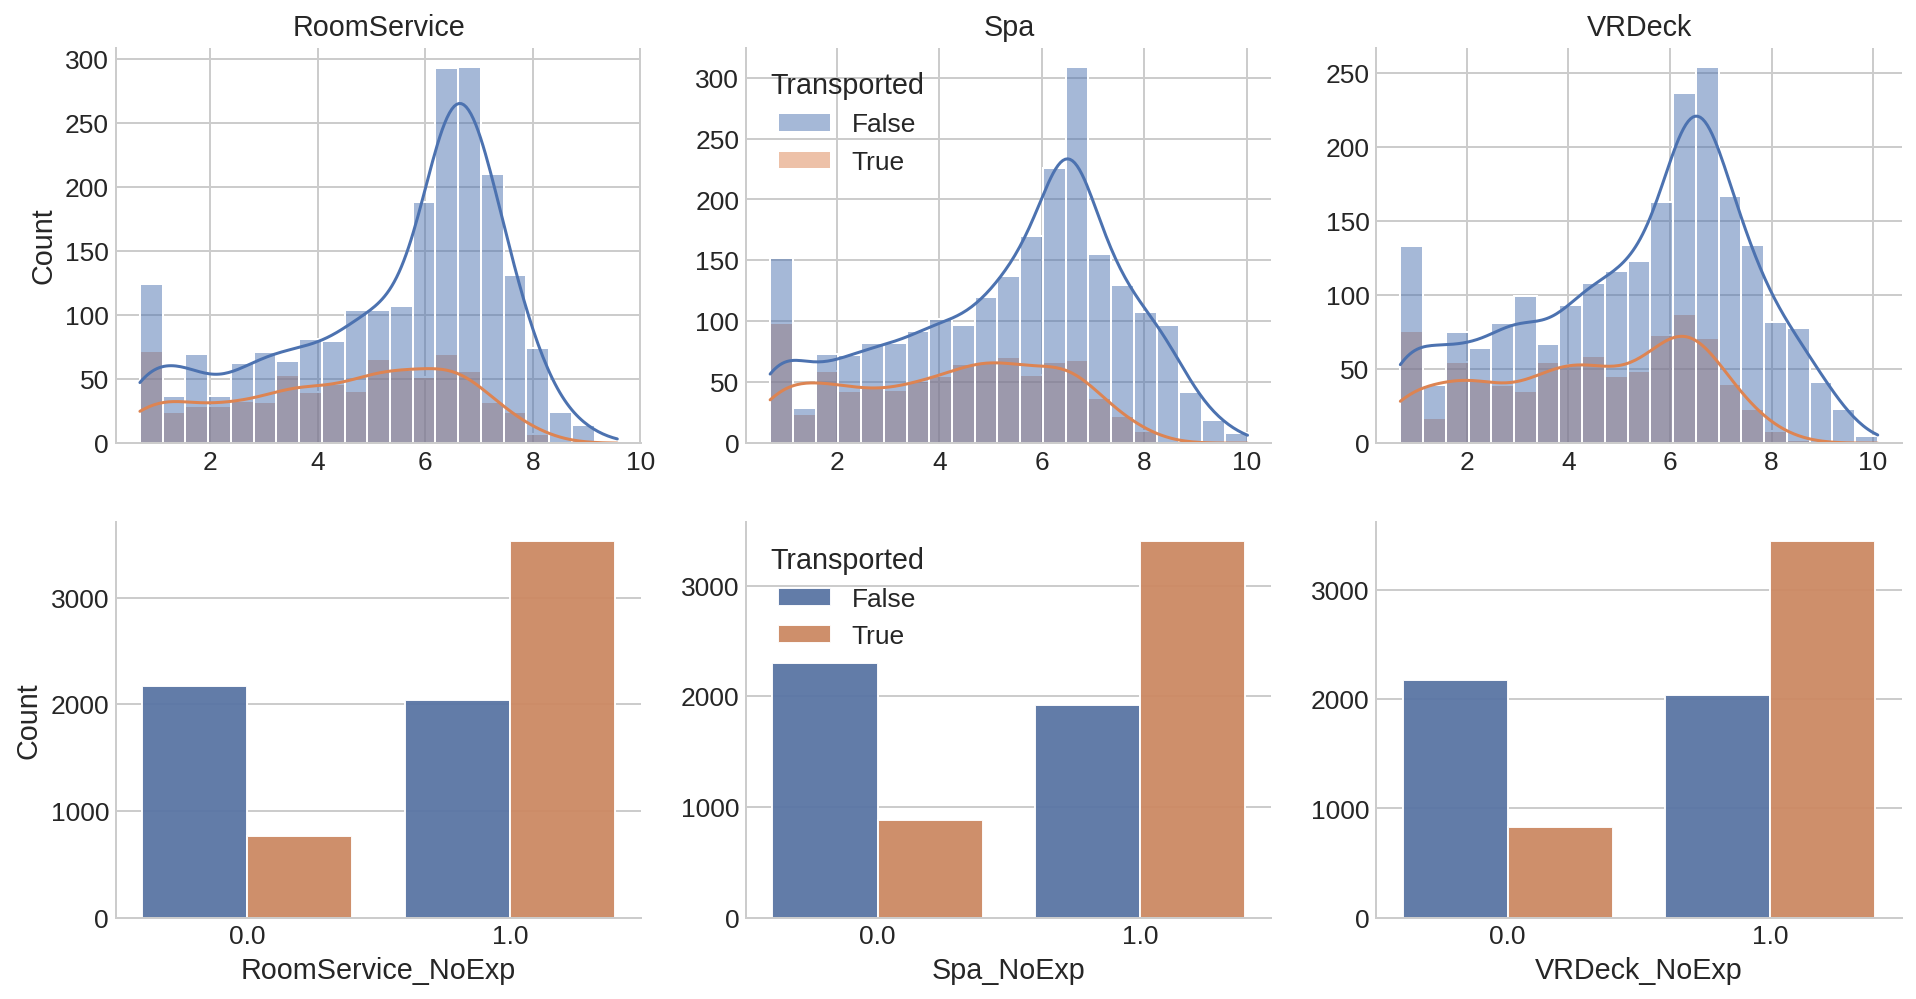

In [84]:
visual = train.copy()

# Compute total expenses
visual['TotalExpenses'] = visual['RoomService'] + visual['Spa'] + visual['VRDeck'] + visual['FoodCourt'] + visual['ShoppingMall']

# Plot features
features = ['RoomService', 'Spa', 'VRDeck']
plot_numerical_features(features) 

In [85]:
log_scale = list(np.linspace(2, 10, 5))
original_scale = []
for l in log_scale: original_scale.append('{:.0f}'.format(np.exp(l) - 1))
pd.DataFrame({'log_scale':log_scale, 'original_scale':original_scale})

,log_scale,original_scale
0,2.0,6
1,4.0,54
2,6.0,402
3,8.0,2980
4,10.0,22025


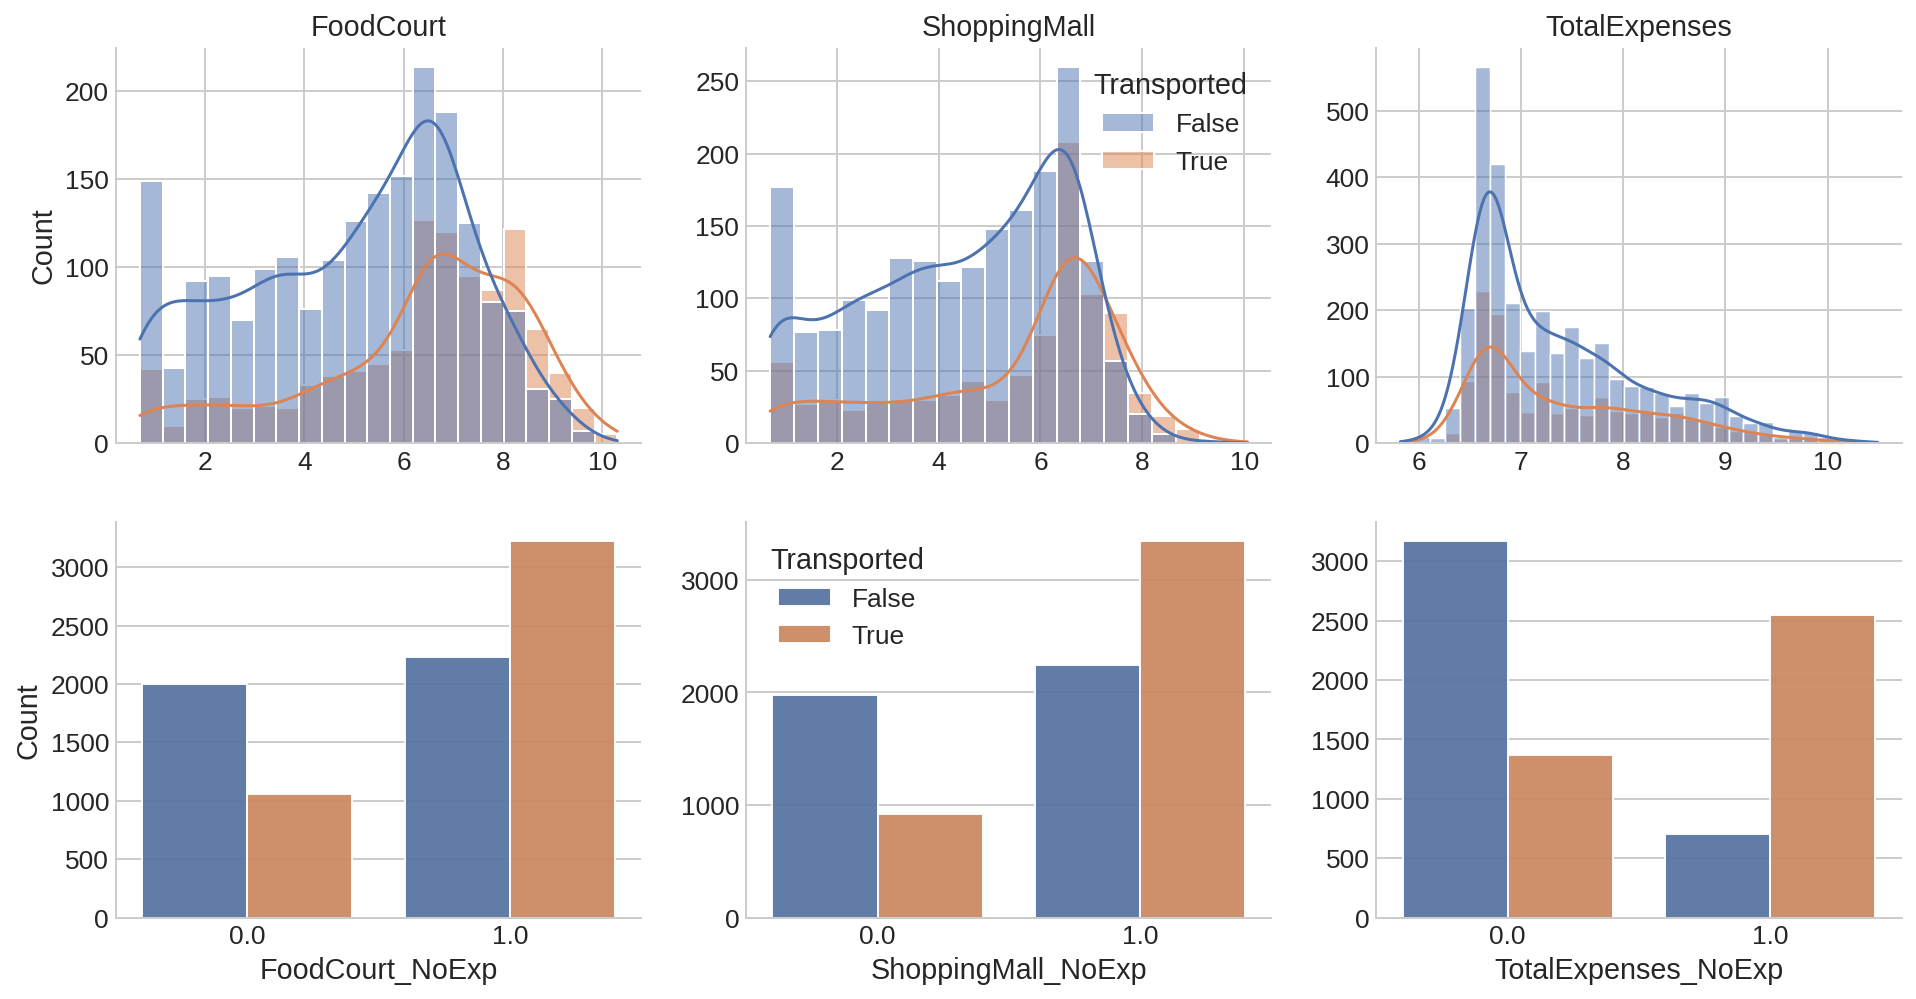

In [86]:
features = ['FoodCourt', 'ShoppingMall', 'TotalExpenses']
plot_numerical_features(features)

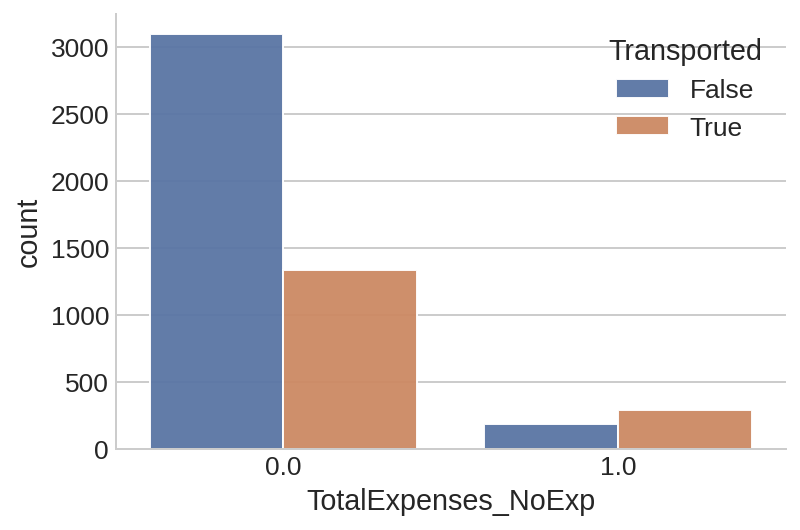

In [87]:
mask = visual['CryoSleep'] == False 
sns.countplot(data=visual[mask], x='TotalExpenses_NoExp', hue='Transported', alpha=0.95, palette=palette)
sns.despine()

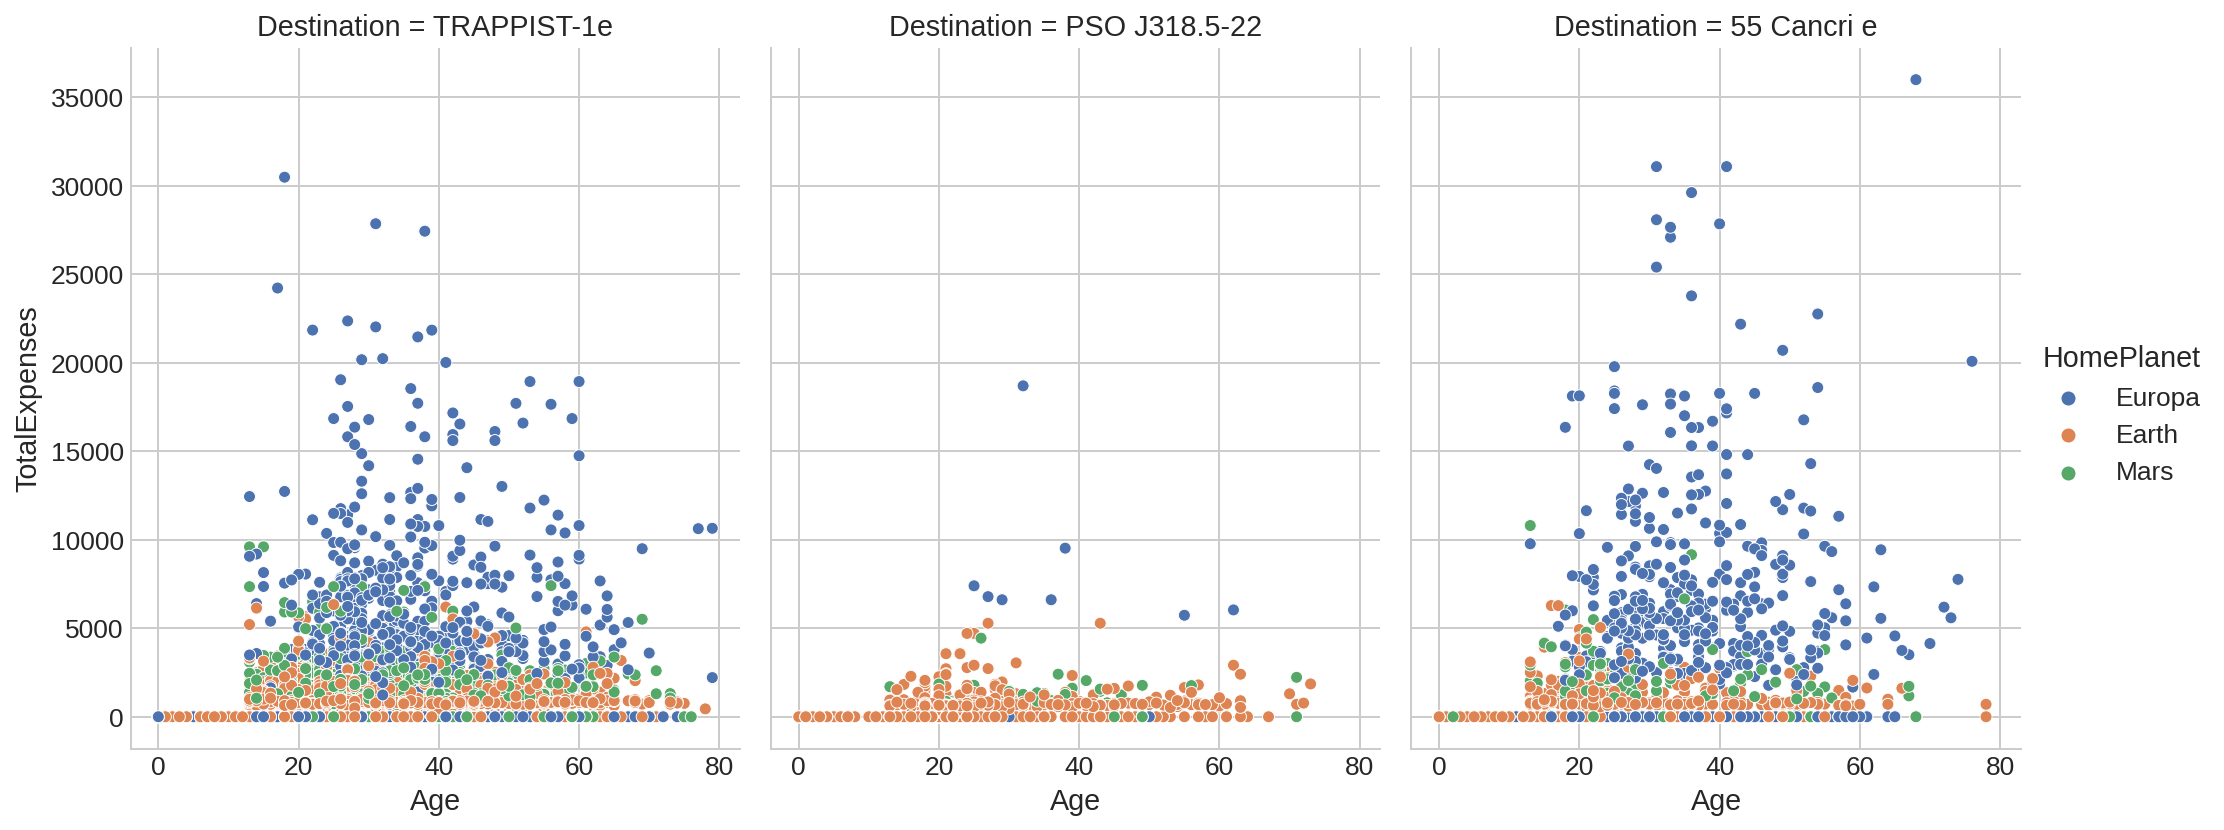

In [88]:
sns.color_palette()
sns.relplot(data=visual, x='Age', y='TotalExpenses', hue='HomePlanet', col='Destination', height=6, aspect=0.8)
sns.despine()

plt.show()

In [89]:
X_train = train.iloc[:,0:-1].copy()
y_train = train.iloc[:,-1].copy()


# Combine train & test
train_id = X_train['PassengerId']
test_id = test['PassengerId']

data = pd.concat([X_train, test], axis=0, ignore_index=True)

# Drop unuseful features
data.drop(columns=['Name', 'VIP'], inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   RoomService   12707 non-null  float64
 7   FoodCourt     12681 non-null  float64
 8   ShoppingMall  12664 non-null  float64
 9   Spa           12686 non-null  float64
 10  VRDeck        12702 non-null  float64
dtypes: float64(6), object(5)
memory usage: 1.1+ MB


In [90]:
data['Pgroup'] = data['PassengerId'].str.split('_', expand=True)[0].copy()
data['Pgroup'].head()

0    0001
1    0002
2    0003
3    0003
4    0004
Name: Pgroup, dtype: object

In [91]:
data['GroupSize'] = 0
groups = list(data.groupby('Pgroup')['Pgroup'].groups.keys())
values = list(data.groupby('Pgroup')['Pgroup'].count())

for group, value in zip(groups, values):
    data.loc[data['Pgroup'] == group, 'GroupSize'] = data.loc[data['Pgroup'] == group, 'GroupSize'].apply(lambda x: value)


# Drop Pgroup
data.drop(columns=['Pgroup'], inplace=True)    

# Create binary feature for group size
data['GroupSize_M'] = data['GroupSize'].apply(group_class)

data.drop(columns=['GroupSize'], inplace=True)

data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupSize_M
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,109.0,9.0,25.0,549.0,44.0,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,43.0,3576.0,0.0,6715.0,49.0,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,0.0,1283.0,371.0,3329.0,193.0,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,303.0,70.0,151.0,565.0,2.0,0


In [92]:
data['DeckSide'] = (data['Cabin'].str.split('/', expand = True)[2]).copy()
data['CabinNumber'] = (data['Cabin'].str.split('/', expand = True)[1]).copy()
data['Cabin'] = (data['Cabin'].str.split('/', expand = True)[0]).copy()

# Create binary feature for deck 
data['Deck_BC'] = data['Cabin'].apply(bool_cabin)

# Drop Cabin
data.drop(columns=['Cabin'], inplace=True)


# Extract cabin groups from cabin number
data.loc[~data['CabinNumber'].isnull(), 'CabinNumber'] = data.loc[~data['CabinNumber'].isnull(), 'CabinNumber'].astype('int32')

labels = ['A', 'B', 'C', 'D', 'E', 'F']

data.loc[~data['CabinNumber'].isnull(), 'CabinGroup'] = pd.cut(data.loc[~data['CabinNumber'].isnull(), 'CabinNumber'], 6, labels=labels)

# Create binary feature for cabin group
data['CabinGroup'] = data['CabinGroup'].apply(extract_cabin_group)
data.drop(columns=['CabinNumber'], inplace=True)

data.head()


,PassengerId,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupSize_M,DeckSide,Deck_BC,CabinGroup
0,0001_01,Europa,False,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0,P,1.0,1.0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,109.0,9.0,25.0,549.0,44.0,0,S,0.0,1.0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,43.0,3576.0,0.0,6715.0,49.0,0,S,0.0,1.0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,0.0,1283.0,371.0,3329.0,193.0,0,S,0.0,1.0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,303.0,70.0,151.0,565.0,2.0,0,S,0.0,1.0


In [93]:
def encode_DeckSide(value):
    if value=='P':
        return 1
    elif value=='S':
        return 0
    else:
        return value
    
    
def encode_dest(destination):
    
    if(destination=='TRAPPIST-1e'):
        destination = 1
    elif(destination=='PSO J318.5-22'):
        destination = 2
    elif(destination=='55 Cancri e'):
        destination = 3

    return destination
def encode_planet(planet):
    
    if(planet=='Earth'):
        planet = 1
    elif(planet=='Europa'):
        planet = 2
    elif(planet=='Mars'):
        planet = 3

    return planet


def encode_bool(value):
    
    if(np.isnan(value)):
        return value
    elif(value):
        value = 1
    elif(~value):
        value = 0

    return value

data['DeckSide'] = data['DeckSide'].apply(encode_DeckSide)
data['Destination'] = data['Destination'].apply(encode_dest)
data['HomePlanet'] = data['HomePlanet'].apply(encode_planet)
data['CryoSleep'] = data['CryoSleep'].apply(encode_bool)

data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupSize_M,DeckSide,Deck_BC,CabinGroup
0,0001_01,2.0,0.0,1.0,39.0,0.0,0.0,0.0,0.0,0.0,0,1.0,1.0,1.0
1,0002_01,1.0,0.0,1.0,24.0,109.0,9.0,25.0,549.0,44.0,0,0.0,0.0,1.0
2,0003_01,2.0,0.0,1.0,58.0,43.0,3576.0,0.0,6715.0,49.0,0,0.0,0.0,1.0
3,0003_02,2.0,0.0,1.0,33.0,0.0,1283.0,371.0,3329.0,193.0,0,0.0,0.0,1.0
4,0004_01,1.0,0.0,1.0,16.0,303.0,70.0,151.0,565.0,2.0,0,0.0,0.0,1.0


In [94]:
# Percentages of missing values
missing = round(100 * data.isnull().sum() / data.shape[0], 2)
missing_df = pd.DataFrame({'% of missing values':missing})
missing_df

,% of missing values
PassengerId,0.00
HomePlanet,2.22
CryoSleep,2.39
Destination,2.11
Age,2.08
RoomService,2.03
FoodCourt,2.23
ShoppingMall,2.36
Spa,2.19
VRDeck,2.07


In [95]:
numeric_columns = ['HomePlanet', 'CryoSleep', 'Destination', 'DeckSide', 'Deck_BC', 'CabinGroup', 'GroupSize_M', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

knn_imputer = KNNImputer(n_neighbors=2)

data[numeric_columns] = pd.DataFrame(knn_imputer.fit_transform(data[numeric_columns]), columns = numeric_columns)

In [96]:

missing = round(100 * data.isnull().sum() / data.shape[0], 2)
missing_df = pd.DataFrame({'% of missing values':missing})
missing_df

,% of missing values
PassengerId,0.0
HomePlanet,0.0
CryoSleep,0.0
Destination,0.0
Age,0.0
RoomService,0.0
FoodCourt,0.0
ShoppingMall,0.0
Spa,0.0
VRDeck,0.0


In [97]:
def clean_labels_1(value):
    if value >= 0.5:
        return 1
    else:
        return 0
    
def clean_labels_2(value):
    if value >= 2.5:
        return 3
    elif value >=1.5 and value < 2.5:
        return 2
    else:
        return 1
    
for feature in ['CryoSleep', 'DeckSide', 'Deck_BC', 'CabinGroup', 'GroupSize_M']:
    data[feature] = data[feature].apply(clean_labels_1)
    
for feature in ['HomePlanet', 'Destination']:
    data[feature] = data[feature].apply(clean_labels_2)

In [98]:
X_train = data[data['PassengerId'].isin(train_id)]

X_train = X_train.drop(columns = ['PassengerId'])

X_test = data[data['PassengerId'].isin(test_id)]

X_test = X_test.drop(columns = ['PassengerId'])

In [99]:
def plot_learning_curve(X, y, estimator, ax):

    train_sizes, train_scores, test_scores = learning_curve(
                                                    estimator=estimator,
                                                    X=X,
                                                    y=y,
                                                    train_sizes=np.linspace(0.1, 1.0, 10),
                                                    cv=8,
                                                    n_jobs=-1)
    
    train_mean_acc = np.mean(train_scores, axis=1)  
    train_std_acc = np.std(train_scores, axis=1)
    test_mean_acc = np.mean(test_scores, axis=1)
    test_std_acc = np.std(test_scores, axis=1)
    
    f = plt.figure(figsize=(9,5))
    
    ax.set_ylim(0.7, 0.95)

    ax.plot(train_sizes, train_mean_acc, label='Training curve', linestyle='-', marker='o', color='g')

    ax.fill_between(train_sizes, train_mean_acc + train_std_acc, train_mean_acc - train_std_acc, alpha=0.15, color='g')
    ax.fill_between(train_sizes, train_mean_acc + train_std_acc, train_mean_acc - train_std_acc, alpha=0.15, color='g')

    ax.plot(train_sizes, test_mean_acc, label='Validation curve', linestyle='--', marker='o', color='r')

    ax.fill_between(train_sizes, test_mean_acc + test_std_acc, test_mean_acc - test_std_acc, alpha=0.15, color='r')

    ax.set_xlabel('Training Sample Size')

    ax.set_ylabel('Accuracy')

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fancybox=True, shadow=True)
    
    return None

Best score: 79.5% +/- 1.8%


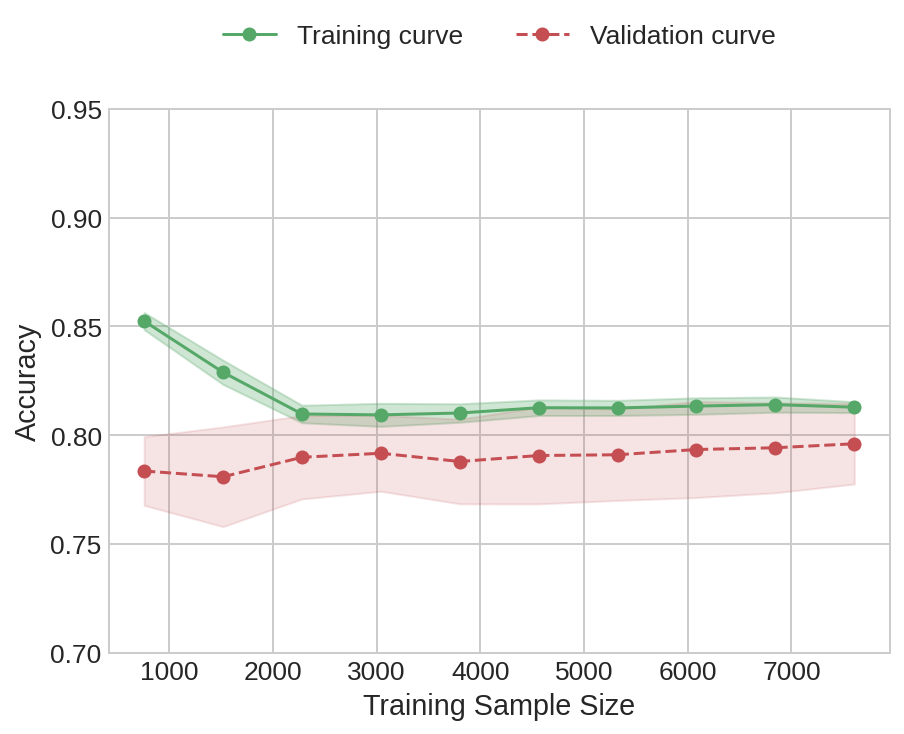

<Figure size 648x360 with 0 Axes>

In [100]:
xgb_model = xgb.XGBClassifier()

scores = cross_val_score(xgb_model, X_train, y_train, scoring='accuracy', cv=8)

mean_score = np.mean(scores)
std_score = np.std(scores)

print('Best score: {:.1f}% +/- {:.1f}%'.format(mean_score*100, std_score*100))

# Fit
xgb_model.fit(X_train, y_train)

# Plot learning curve
fig, ax = plt.subplots(figsize=(7, 5))
plot_learning_curve(X_train, y_train, xgb_model, ax=ax)
plt.show()

Best score: 80.0% +/- 1.9%


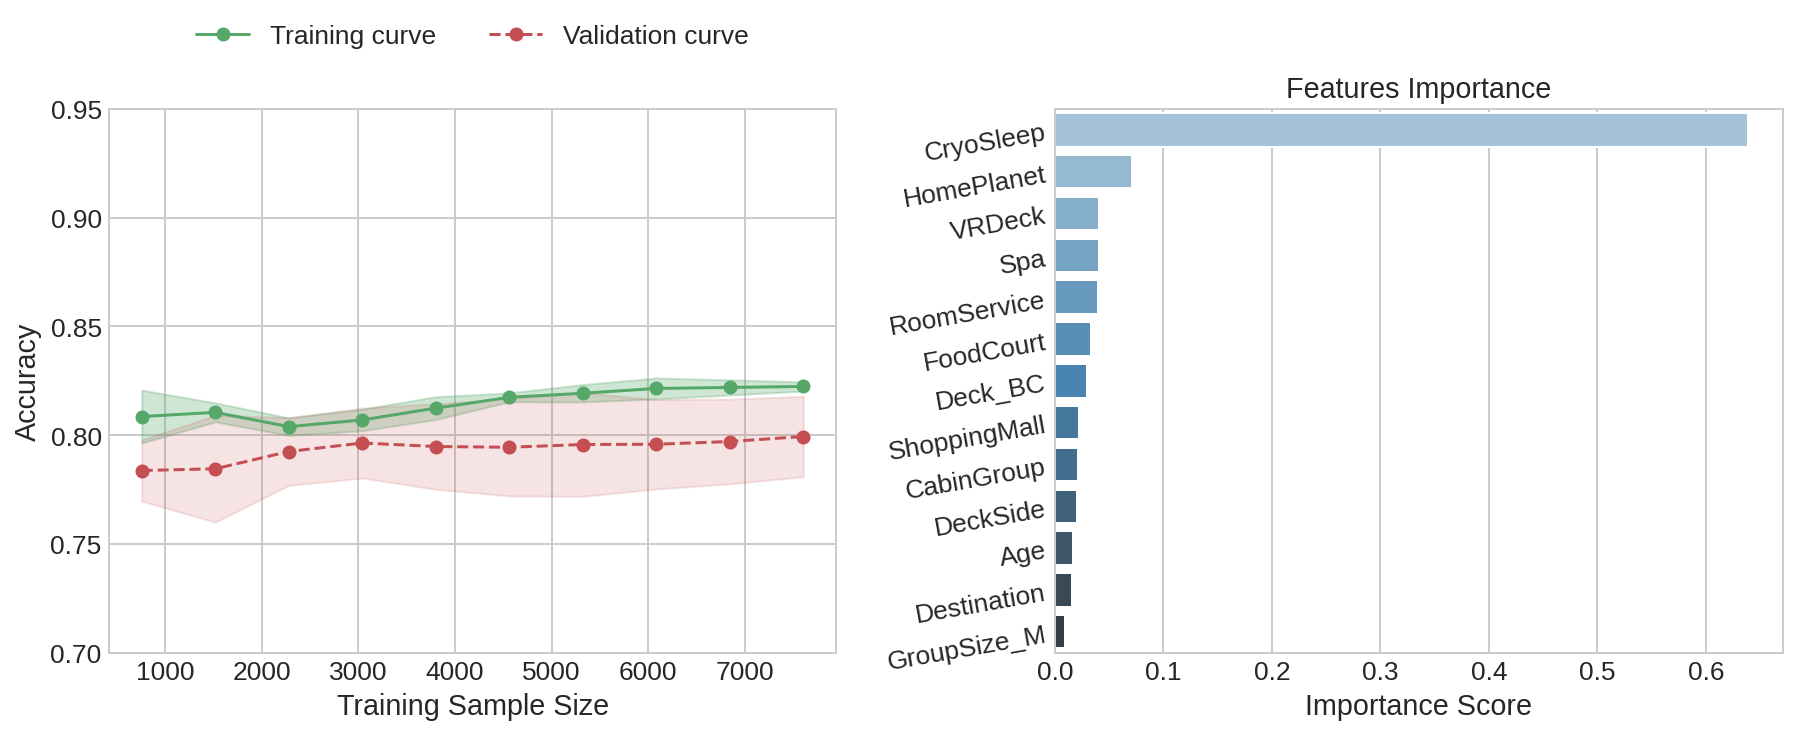

<Figure size 648x360 with 0 Axes>

In [101]:
xgb_model = xgb.XGBClassifier(n_estimators=400,
                              learning_rate=0.05, # [0, 1] > variance
                              min_split_loss = 6, # > bias
                              max_depth=10, # > variance
                              min_child_weight=2, # > bias
                              subsample=0.8, # [0,1] > variance (< 1 prevents overfitting)
                              reg_lambda=2,
                              reg_alpha=2,
                              objective='binary:logistic',
                              eval_metric = "rmse",
                              colsample_bytree=1) # [0, 1]

scores = cross_val_score(xgb_model, X_train, y_train, scoring='accuracy', cv=8)

mean_score = np.mean(scores)
std_score = np.std(scores)

print('Best score: {:.1f}% +/- {:.1f}%'.format(mean_score*100, std_score*100))

# Fit
xgb_model.fit(X_train, y_train)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.subplots_adjust(wspace=0.3)

plot_learning_curve(X_train, y_train, xgb_model, ax=axs[0])


xgb_var_imp_df = pd.DataFrame({'var':X_train.columns,
                              'importance':xgb_model.feature_importances_}).sort_values(by='importance',ascending=False)


sns.barplot(data=xgb_var_imp_df, y='var', x='importance', orient='h', palette='Blues_d', ax=axs[1])
axs[1].set_title('Features Importance')
axs[1].set_ylabel('')
axs[1].set_xlabel('Importance Score')
axs[1].tick_params(axis='y', labelrotation=10)

plt.show()

In [102]:
y_pred = xgb_model.predict(X_test)

test_survived = pd.Series(y_pred, name='Transported')

test_survived.head(3)
test_survived.to_csv('submission3.csv', index=False)
